# GARPOS Notebook 
### This notebook demonstrates how to run the [GARPOS](https://github.com/s-watanabe-jhod/garpos) GNSS-A processing software in the EarthScope GeoLab cloud environment.  
11-07-2025

### GeoLab Basics

GeoLab is the name of EarthScope's Jupyter Hub, which allows users to run code via Jupyter notebooks (or in a terminal) on EarthScope resources in AWS.  

The `sfg-geolab` image comes pre-loaded with the software needed to process GNSS-A data. Each user has their own home directory `/home/jovyan` that is mounted to 
the image and any files kept there are accessibile only to that user and remain during future sessions.  

### Data 
Currently, we have pre-processed `cascadia-gorda` data and stored the shotdata in an S3 bucket accessible to users authorized to use the `s3-seafloor` role.  

Please contact mike.gottlieb@earthscope.org to request access to this role.

Raw data is available to anyone with an earthscope account via authenticated https from [https://data.earthscope.org/archive/seafloor](https://data.earthscope.org/archive/seafloor).

### Metadata
In order to simplify our interactions with the various metadata formats, we are translating all metadata into `site` and `vessel` json. We store and load these metadata from the S3 archive [https://data.earthscope.org/archive/seafloor/metadata](https://data.earthscope.org/archive/seafloor/metadata)

The site metadata file is stored at `/home/joyvan/[network]/[site]/[metadata]/`

### Results
Results are stored per GARPOS run under `/home/joyvan/[network]/[site]/[campaign]/[survey]/GARPOS/results`

### Logs
Some log output is piped to the notebook.  Additionally, specific survey logs are written to `/home/joyvan/[network]/[site]/[campaign]/[survey]/GARPOS/logs`

## Import Modules

In [1]:
import os

from es_sfgtools.config.env_config import Environment
from es_sfgtools.workflows.workflow_handler import WorkflowHandler
from earthscope_sdk import AsyncEarthScopeClient
from earthscope_sdk.config.settings import SdkSettings

#this reads environment variables set in the image
Environment.load_working_environment()

## Grab temporary AWS credentials for the s3-seafloor role
For more information on the EarthScope SDK, read the [documentation](https://docs.earthscope.org/projects/SDK/en/stable/intro.html). 

If you do not have authorization for this role and think you should, email a request to mike.gottlieb@earthscope.org with your EarthScope login id.  

In [2]:
#Enter the network, station, and campaign of interest
network = "cascadia-gorda"
station = "NCC1"
campaign_name = '2023_A_1063'

# Create an EarthScope client 
es = AsyncEarthScopeClient()
# Set AWS credentials for S3 access
creds = await es.user.get_aws_credentials(role="s3-seafloor")

os.environ['AWS_ACCESS_KEY_ID'] = creds.aws_access_key_id
os.environ['AWS_SECRET_ACCESS_KEY'] = creds.aws_secret_access_key
os.environ['AWS_SESSION_TOKEN']  = creds.aws_session_token

## Select the data you are interested in running through GARPOS
Currently we have pre-processed all campaigns for stations **GCC1**, **NBR1**, **NCC1** and **NTH1** in network **cascadia-gorda** and made shotdata available to this environment in a shared S3 bucket.

Available Cascadia Campaigns
|        | GCC1        | NBR1        | NCC1        | NTH1        |
|--------|-------------|-------------|-------------|-------------|
| **2022** | 2022_A_1065 |             | 2022_A_1065 |             |
| **2023** | 2023_A_1063 | 2023_A_1063 | 2023_A_1063 |             |
| **2024** | 2024_A_1126 | 2024_A_1126 | 2024_A_1126 |             |
| **2025** | 2025_A_1126 | 2025_A_1126 | 2025_A_1126 | 2025_A_1126 |

#### Select the network, station and campaign (above) that you want to run in the cell below. 


In [3]:
NETWORK = "cascadia-gorda"
STATION = "GCC1"
CAMPAIGN = "2025_A_1126"

## Set up the workflow with your chosen site/campaign

A `workflow` is a wrapper containing methods to access all the processing steps.
For more information on the `WorkflowHandler` class, check out our [ReadTheDocs](https://es-sfgtools.readthedocs.io/en/latest/api/es_sfgtools.workflows.workflow_handler.html) documentation. 

In [4]:
workflow = WorkflowHandler()

workflow.set_network_station_campaign(
    network_id=NETWORK,
    station_id=STATION,
    campaign_id=CAMPAIGN
)

Changed working station to cascadia-gorda GCC1 2025_A_1126


## Prepare data for GARPOS Processing 

Optional Variables to include in `mid_process_prep_garpos()`
  * `site_metadata`: Site metadata or path to metadata file. If not provided, it will be loaded if available.
    * Default: None
  * `survey_id`: Survey identifier to process. If None, processes all surveys
    * Default: None
  * `custom_filters`: Custom filter settings for shot data preparation
    * Default: None
  * `override`: True/False. If true, re-prepares existing data.
    * Default: False
  * `write_intermetediate`: True/False, If true, writes intermediate files.
    * Default: False

A value error will be raised if site metadata is not loaded. 

*For more information on this fucntion, check out our [ReadTheDocs](https://es-sfgtools.readthedocs.io/en/latest/api/es_sfgtools.workflows.workflow_handler.html#es_sfgtools.workflows.workflow_handler.WorkflowHandler.midprocess_prep_garpos)*

#### **Optional** 
Set up custom filters in the dictionary provided in the cell below.  These filters will reduce the number of samples being fed into GARPOS

In [5]:
# OPTIONAL: Edit the filter config as needed
FILTER_CONFIG = {
    "pride_residuals": {
        "enabled": False,
        "max_residual_mm": 8,
        "description": "Filter based on GNSS positioning residuals",
    },
    "max_distance_from_center": {
        "enabled": False,
        "max_distance_m": 150.0,
        "description": "Filter shots beyond maximum distance from array center",
    },
    "ping_replies": {
        "enabled": False,
        "min_replies": 1,
        "description": "Filter based on minimum acoustic ping replies",
    },
    "acoustic_filters": {
        "enabled": False,
        "level": "OK",
        "description": "Apply standard acoustic data quality filters",
    },
}

### Run the prep function

If you added custom filters above, add `custom_filters=FILTER_CONFIG` to the function below.  Custom filters are not required.

By default, filters are all disabled, except for center point surveys the max_distance_m defaults to 150.

In [7]:
# Prepare GARPOS data, insert custom filters if desired or other variables described above
workflow.midprocess_prep_garpos() #custom_filters=FILTER_CONFIG)

Network cascadia-gorda already exists.
Station GCC1 already exists in network cascadia-gorda
Campaign 2022_A_1065 already exists in station GCC1
Campaign 2023_A_1063 already exists in station GCC1
Campaign 2024_A_1126 already exists in station GCC1
Campaign 2025_A_1126 already exists in station GCC1


Processing survey 2025_A_1126_1
Processing survey 2025_A_1126_2


## Run Garpos
This will loop through all the surveys in the campaign and run GARPOS on each.  

You can change the above inversion parameters and run again to compare results, but make sure to increment run_id so that the results are stored in a new directory.


Optional Variables to include in `modeling_run_garpos()`
  * `survey_id`: Optional survey identifier to process. If None, processes all surveys
    * Default: None
  * `run_id`: Identifier for the GARPOS run 
    * Default: "Test"
  * `iterations`: Number of GARPOS iterations to perform.  Multiple iterations can improve results, but increases processing runtime.
    * Default: 1  
  * `site_metadata`: Site metadata or local path to metadata file. If not provided, available metadata will be loaded from the archive.
    * Default: None
  * `override`: True/False. If true, re-runs GARPOS even if results exist.
    * Default False
  * `custom_settings`: Custom GARPOS settings to apply
    * GARPOS settings
        * Inversion Parameters - for more information: https://github.com/s-watanabe-jhod/garpos/blob/master/sample/Settings-prep.ini
            * `spline_degree` Default: 3
            * `log_lambda`  Smoothness parameter for background perturbation (in log10 scale) Default: [0]
            * `log_gradlambda` Smoothness parameter for spatial gradient ( = Lambda0 * gradLambda ) Default: -1
            * `mu_t`  Correlation length of data for transmit time (in min.) Default: [0.0]
            * `mu_mt`  Data correlation coefficient b/w the different transponders. Default: [0.5]
            * `knotint0` Typical Knot interval (in min.) for gamma's component (a0, a1, a2). Note ;; shorter numbers recommended, but consider the computational resources.  If knotint = 0, relevant component is fixed to be zero. Default: 5
            * `knotint1` Typical Knot interval (in min.) for gamma's component (a0, a1, a2). Note ;; shorter numbers recommended, but consider the computational resources.  If knotint = 0, relevant component is fixed to be zero. Default: 0
            * `knotint2` Typical Knot interval (in min.) for gamma's component (a0, a1, a2). Note ;; shorter numbers recommended, but consider the computational resources.  If knotint = 0, relevant component is fixed to be zero. Default: 0
            * `rejectcriteria`  Criteria for the rejection of data (+/- rsig * Sigma). if = 0, no data will be rejected during the process. This parameter should be 0 when applying ABIC search. Default: 2
            * `inversiontype`  Default: positions Options: positions, gammas, both
            * `positionalOffset` Positional offset for the inversion. Default: [0.0, 0.0, 0.0]
            * `traveltimescale`  Typical measurement error for travel time.  (= 1.e-4 sec is recommended in 10 kHz carrier) Default: 1.0e-4
            * `maxloop`  Maximum loop for iteration. Default: 50
            * `convcriteria`  Convergence criteria for model parameters. Default: 5.0e-3
            * `deltap` Infinitesimal values to make Jacobian matrix. Default: 1.0e-6
            * `deltab`  Infinitesimal values to make Jacobian matrix. Default: 1.0e-6
            * `delta_center_position` Delta Center Position. Default: 1, 1, 1

  *For more information on this function, check out our [ReadTheDocs](https://es-sfgtools.readthedocs.io/en/latest/api/es_sfgtools.workflows.workflow_handler.html#es_sfgtools.workflows.workflow_handler.WorkflowHandler.modeling_run_garpos)*

### Set up any custom settings


In [11]:
# Example custom settings for GARPOS inversion
GARPOS_CUSTOM_SETTINGS = {
    'inversion_params' : {
        'maxloop': 5 # Maximum number of inversion loops
        }
    }

### View available survey metadata

In [23]:
for campaign in workflow.current_station_metadata.campaigns:
    if campaign.name == campaign_name:
        surveys = campaign.surveys
        print(f"The campaign {station} {campaign.name} contains {len(surveys)} survey patterns\n")
        for i, survey in enumerate(surveys):
            print(f" {i+1}. Survey Name: {survey.id}")
            print(f"     Survey Type: {survey.type.value} ({survey.notes if survey.notes is not None else ''})")
            print(f"     {survey.start} to {survey.end}")
            print(f"     Survey length: {survey.end - survey.start}\n")

The campaign NCC1 2023_A_1063 contains 3 survey patterns

 1. Survey Name: 2023_A_1063_1
     Survey Type: circledrive (Visual identification)
     2023-09-14 15:51:48.870000 to 2023-09-15 09:28:31.870000
     Survey length: 17:36:43

 2. Survey Name: 2023_A_1063_2
     Survey Type: center (Visual identification)
     2023-09-15 09:28:48.870000 to 2023-09-20 17:28:31.870000
     Survey length: 5 days, 7:59:43

 3. Survey Name: 2023_A_1063_3
     Survey Type: center (Visual identification)
     2023-09-21 21:15:48.870000 to 2023-09-24 17:58:31.870000
     Survey length: 2 days, 20:42:43



### Set up run ID and survey (if needed)

In [24]:
SURVEY_NUMBER = 1
SURVEY_ID=f"{CAMPAIGN}_{SURVEY_NUMBER}"

RUN_ID = "1"   # Change name or number for each GARPOS run to avoid overwriting previous results

### Run garpos with options outlined above

In [25]:
workflow.modeling_run_garpos(run_id=RUN_ID, 
                             survey_id=SURVEY_ID, 
                             custom_settings=GARPOS_CUSTOM_SETTINGS)

Running GARPOS model. Run ID: 1
Running GARPOS model for survey 2025_A_1126_1. Run ID: 1
Running GARPOS model for survey 2025_A_1126_1. Run ID: 1
Iteration 1 of 1 for survey 2025_A_1126_1
Running GARPOS model for GCC1, . Run ID: 0


  suffix  lamb0  lgrad  mu_t  mu_m
0     _0    1.0    0.1   0.0   0.5


/opt/conda/lib/python3.11/site-packages/tiledb/ctx.py:605: UserWarning: TileDB is a multithreading library and deadlocks are likely if fork() is called after a TileDB context has been created (such as for array access). To safely use TileDB with multiprocessing or concurrent.futures, choose 'spawn' as the start method for child processes. For example: multiprocessing.set_start_method('spawn').
  warnings.warn(


Inversion loop 001, RMS(TT) =  20.836637 ms, used_shot =  91.2%, reject =  324, Max(dX) =    10.0000, Hgt =  -3104.928
Inversion loop 002, RMS(TT) =  15.198097 ms, used_shot =  88.3%, reject =  431, Max(dX) =    10.0000, Hgt =  -3109.583
Inversion loop 003, RMS(TT) =  10.328357 ms, used_shot =  85.7%, reject =  528, Max(dX) =    10.0000, Hgt =  -3113.412
Inversion loop 004, RMS(TT) =   6.061781 ms, used_shot =  83.4%, reject =  613, Max(dX) =    10.0000, Hgt =  -3116.574
Inversion loop 005, RMS(TT) =   2.119463 ms, used_shot =  81.7%, reject =  678, Max(dX) =    10.0000, Hgt =  -3119.445
 ABIC =       41376.323766  misfit =  10.820 _0
/home/jovyan/cascadia-gorda/GCC1/2025_A_1126/2025_A_1126_1/GARPOS/results/run_1/GCC1.2025_A_1126_0-res.dat


Processing GARPOS results
GARPOS results processed, returning results tuple


## Plot Results

Plot results from GARPOS run(s). 

Optional Parameters
  * `survey_id`: ID of the survey to plot results for
    * Default: None
  * `run_id`: The run ID of the survey results to plot
    * Default: "test"
  * `res_filter`: The residual filter value to filter outrageous values (m).
    * Default: 10
  * `save_fig`: True/False. If true, save the figure created.
    * Default: True
  * `show_fig`: True/False. If true, display figure.
    * Default True

  *For more information on this function, check out our [ReadTheDocs](https://es-sfgtools.readthedocs.io/en/latest/api/es_sfgtools.workflows.workflow_handler.html#es_sfgtools.workflows.workflow_handler.WorkflowHandler.modeling_plot_garpos_results)*


Using data file /home/jovyan/cascadia-gorda/GCC1/2025_A_1126/2025_A_1126_1/GARPOS/results/run_1/GCC1.2025_A_1126_0-res.dat for plotting.


Array Final Position: East 225.8312 m, North -20.7381 m, Up -3142.4667 m
 Sig East 0.28 m  Sig North 0.29 m  Sig Up 4.59 m 
Array Delta Position :  East -0.360 m, North -0.184 m, Up -23.021 m 
TSP M5209 : East 93.692 m, North 2836.023 m, Up -3095.750 m 
TSP M5210 : East -2088.164 m, North -1937.118 m, Up -3097.182 m 
TSP M5211 : East 2674.123 m, North -960.018 m, Up -3096.340 m 



Skipping plotting for survey 2025_A_1126_2: No .dat files found in run directory /home/jovyan/cascadia-gorda/GCC1/2025_A_1126/2025_A_1126_2/GARPOS/results/run_1.


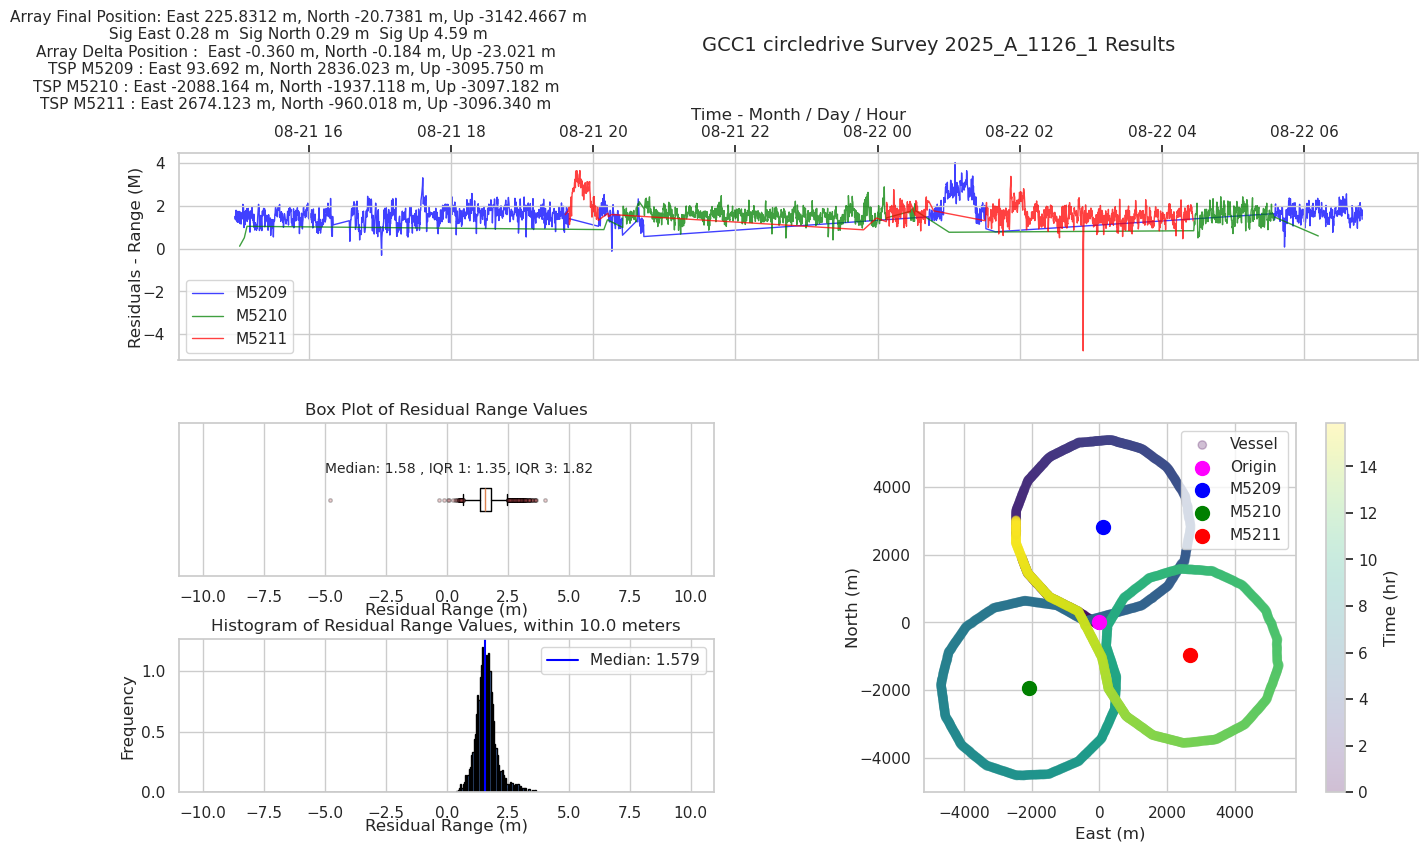

In [26]:
workflow.modeling_plot_garpos_results(run_id=RUN_ID)